In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('/home/ubuntu/fastai/')
from fastai.imports import *

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
import warnings
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', DeprecationWarning)

In [3]:
from fastai.conv_learner import *

In [4]:
PATH = "/home/ubuntu/data/cifar/"
OUTPATH = "/home/ubuntu/data/cifar10/"
os.makedirs(PATH,exist_ok=True)

In [5]:
import shutil
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [6]:
for x in classes:
    os.makedirs(OUTPATH+'train/'+x,exist_ok=True)
    os.makedirs(OUTPATH+'val/'+x,exist_ok=True) 

In [7]:
filenames = os.listdir(PATH+'train/')
counts = {x:0 for x in classes}
print(len(filenames))

50000


In [8]:
valset_size = len(filenames) / 10 * .2
for file_n in filenames:
    for x in classes:
        if x in file_n:
            counts[x] = counts[x] +1
            if counts[x] < valset_size:
                shutil.copyfile(PATH+'train/'+file_n, OUTPATH+'val/'+x+'/'+file_n)
            else:
                shutil.copyfile(PATH+'train/'+file_n, OUTPATH+'train/'+x+'/'+file_n)
        if 'automobile' in file_n:
            counts['car'] = counts['car'] +1
            if counts[x] < valset_size:
                shutil.copyfile(PATH+'train/'+file_n, OUTPATH+'val/car/'+file_n)
            else:
                shutil.copyfile(PATH+'train/'+file_n, OUTPATH+'train/car/'+file_n)

In [9]:
filenames = os.listdir(PATH+'test/')
for file_n in filenames:
    shutil.copy(PATH+'test/'+file_n, OUTPATH+'test/'+file_n)

In [10]:
def get_data(sz,bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=None, pad=sz//8)
    return ImageClassifierData.from_paths(OUTPATH, val_name='val', tfms=tfms, bs=bs)

In [11]:
data = get_data(32,4)

In [12]:
x,y=next(iter(data.trn_dl))

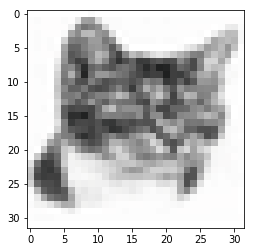

In [13]:
plt.imshow(data.trn_ds.denorm(x)[0]);

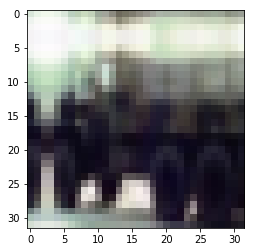

In [14]:
plt.imshow(data.trn_ds.denorm(x)[1]);

In [15]:
bs=256

In [16]:
data = get_data(32,4)

In [17]:
x,y=next(iter(data.trn_dl))

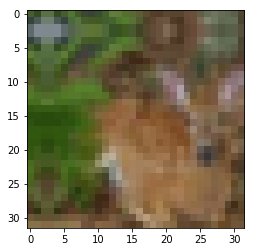

In [18]:
plt.imshow(data.trn_ds.denorm(x)[0]);

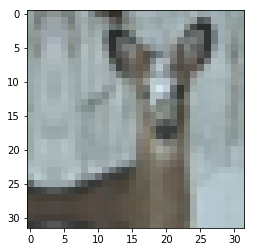

In [19]:
plt.imshow(data.trn_ds.denorm(x)[1]);

In [20]:
data = get_data(32,bs)

In [21]:
lr=1e-2

In [23]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [24]:
learn = ConvLearner.from_model_data(SimpleNet([32*32*3, 40,10]), data)

In [25]:
learn, [o.numel() for o in learn.model.parameters()]

(SimpleNet(
   (layers): ModuleList(
     (0): Linear(in_features=3072, out_features=40, bias=True)
     (1): Linear(in_features=40, out_features=10, bias=True)
   )
 ), [122880, 40, 400, 10])

In [26]:
learn.summary()

OrderedDict([('Linear-1',
              OrderedDict([('input_shape', [-1, 3072]),
                           ('output_shape', [-1, 40]),
                           ('trainable', True),
                           ('nb_params', tensor(122920))])),
             ('Linear-2',
              OrderedDict([('input_shape', [-1, 40]),
                           ('output_shape', [-1, 10]),
                           ('trainable', True),
                           ('nb_params', tensor(410))]))])

In [27]:
learn.lr_find()

 74%|███████▍  | 145/196 [00:13<00:04, 10.52it/s, loss=2.67]

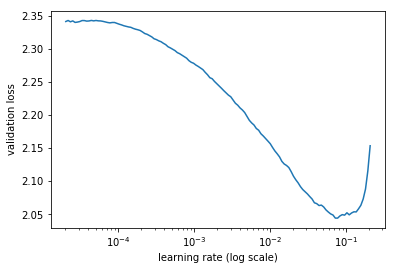

In [28]:
learn.sched.plot()

In [29]:
%time learn.fit(lr, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.759018   1.648455   0.420694  
    1      1.683243   1.580469   0.442952                   
CPU times: user 1min 11s, sys: 32.7 s, total: 1min 44s
Wall time: 41.8 s


[1.5804686238203016, 0.4429516739469505]

In [30]:
%time learn.fit(lr, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.606226   1.526543   0.464006  
    1      1.597844   1.503018   0.477441                   
CPU times: user 1min 10s, sys: 32.6 s, total: 1min 43s
Wall time: 41.4 s


[1.5030184689231691, 0.4774413473481331]

In [31]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, stride=2)
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [32]:
learn = ConvLearner.from_model_data(ConvNet([3, 20, 40, 80], 10), data)

In [34]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 15, 15]),
                           ('trainable', True),
                           ('nb_params', tensor(560))])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 20, 15, 15]),
                           ('output_shape', [-1, 40, 7, 7]),
                           ('trainable', True),
                           ('nb_params', tensor(7240))])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 40, 7, 7]),
                           ('output_shape', [-1, 80, 3, 3]),
                           ('trainable', True),
                           ('nb_params', tensor(28880))])),
             ('AdaptiveMaxPool2d-4',
              OrderedDict([('input_shape', [-1, 80, 3, 3]),
                           ('output_shape', [-1, 80, 1, 1]),
                           ('nb_params', 0)])),
             ('Linear-5',
 

In [35]:
learn.lr_find(end_lr=100)

 98%|█████████▊| 193/196 [00:17<00:00, 11.11it/s, loss=7.73]

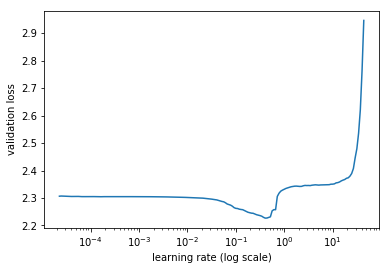

In [36]:
learn.sched.plot()

In [37]:
%time learn.fit(1e-1, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.706015   1.667882   0.381392  
    1      1.502532   1.510269   0.451775                   
CPU times: user 1min 13s, sys: 31.9 s, total: 1min 45s
Wall time: 41.4 s


[1.51026883690874, 0.45177461319560636]

In [38]:
%time learn.fit(1e-1, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.700722   1.60176    0.410367  
    1      1.472171   1.399476   0.492681                   
    2      1.378631   1.31916    0.527371                   
    3      1.32162    1.261166   0.546521                   
CPU times: user 2min 29s, sys: 1min 2s, total: 3min 31s
Wall time: 1min 22s


[1.2611662453846868, 0.54652095369282]

In [39]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x): return F.relu(self.conv(x))

In [40]:
class ConvNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([ConvLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [41]:
learn = ConvLearner.from_model_data(ConvNet2([3, 20, 40, 80], 10), data)

In [42]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', tensor(560))])),
             ('ConvLayer-2',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', tensor(7240))])),
             ('ConvLayer-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 40, 8, 8]),
 

In [43]:
%time learn.fit(1e-1, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.715935   1.583113   0.424002  
    1      1.500381   1.539318   0.445759                   
CPU times: user 1min 14s, sys: 31.3 s, total: 1min 45s
Wall time: 41.3 s


[1.5393183286332979, 0.44575897309161966]

In [44]:
%time learn.fit(1e-1, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.797321   1.730058   0.371065  
    1      1.561667   1.506239   0.459194                   
CPU times: user 1min 14s, sys: 31.2 s, total: 1min 46s
Wall time: 41.4 s


[1.5062388366225345, 0.459193903995416]

In [45]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [46]:
class ConvBnNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [47]:
learn = ConvLearner.from_model_data(ConvBnNet([10, 20, 40, 80, 160], 10), data)

In [48]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', tensor(760))])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', tensor(1800))])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', tensor(7200))])),
             ('BnLayer-5',
   

In [49]:
%time learn.fit(3e-2, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.523029   1.347141   0.514839  
    1      1.306444   1.262058   0.557449                   
CPU times: user 1min 28s, sys: 30.3 s, total: 1min 59s
Wall time: 43.2 s


[1.262058267791548, 0.5574493670071536]

In [50]:
%time learn.fit(1e-1, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.252688   1.100339   0.61159   
    1      1.108193   0.958781   0.664628                   
    2      1.020125   0.867815   0.695709                   
    3      0.95704    0.825667   0.710146                    
CPU times: user 2min 57s, sys: 59.2 s, total: 3min 57s
Wall time: 1min 25s


[0.825667432680239, 0.7101463801592607]

In [53]:
class ConvBnNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([BnLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2 in zip(self.layers, self.layers2):
            x = l(x)
            x = l2(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [54]:
learn = ConvLearner.from_model_data(ConvBnNet2([10, 20, 40, 80, 160], 10), data)

In [55]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', tensor(760))])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', tensor(1800))])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', tensor(3600))])),
             ('BnLayer-5',
 

In [56]:
%time learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.501534   1.319919   0.530279  
    1      1.278789   1.170468   0.584319                   
CPU times: user 1min 44s, sys: 29.5 s, total: 2min 14s
Wall time: 47.5 s


[1.1704679277919925, 0.5843192295318667]

In [57]:
%time learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.083754   0.9874     0.651895  
    1      1.004294   0.868462   0.693503                   
CPU times: user 1min 44s, sys: 30.1 s, total: 2min 14s
Wall time: 47.6 s


[0.8684623707074642, 0.6935031070770423]

In [58]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [59]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [60]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 10), data)

In [61]:
wd=1e-5

In [62]:
%time learn.fit(1e-2, 2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.527421   1.350515   0.514337  
    1      1.284949   1.131471   0.598456                   
CPU times: user 2min 7s, sys: 32.5 s, total: 2min 40s
Wall time: 1min


[1.1314706205006997, 0.598455984427022]

In [63]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.092988   0.95417    0.664026  
    1      1.05422    0.88633    0.683978                   
    2      0.904641   0.818627   0.712051                    
    3      0.970411   0.820361   0.710146                    
    4      0.847219   0.689444   0.758171                    
    5      0.74284    0.621824   0.776218                    
    6      0.680948   0.583609   0.793964                    
CPU times: user 7min 31s, sys: 1min 52s, total: 9min 24s
Wall time: 3min 32s


[0.5836088587938006, 0.7939643068401565]

In [64]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

epoch      trn_loss   val_loss   accuracy                    
    0      0.811753   0.700365   0.751855  
    1      0.715435   0.582837   0.794566                    
    2      0.629164   0.50726    0.820834                    
    3      0.567783   0.471983   0.833567                    
    4      0.701971   0.529296   0.81151                     
    5      0.615903   0.445549   0.841588                    
    6      0.5291     0.374976   0.869862                    
    7      0.473795   0.391394   0.865851                    
    8      0.608306   0.456338   0.840285                    
    9      0.531471   0.372641   0.868859                    
    10     0.440115   0.320615   0.888711                    
    11     0.401379   0.311006   0.893323                    
    12     0.546527   0.394351   0.86144                     
    13     0.470893   0.310267   0.894426                    
    14     0.381569   0.238389   0.921095                    
    15     0.328874   0.22

[0.0996887820957896, 0.9685181466687388]

In [65]:
class Resnet2(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(self.out(x), dim=-1)

In [66]:
learn = ConvLearner.from_model_data(Resnet2([16, 32, 64, 128, 256], 10, 0.2), data)

In [67]:
wd=1e-6

In [68]:
%time learn.fit(1e-2, 2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.753431   1.538384   0.462402  
    1      1.485216   1.308647   0.529878                   
CPU times: user 2min 54s, sys: 34 s, total: 3min 28s
Wall time: 1min 24s


[1.3086467759748344, 0.5298776811723459]

In [69]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.247727   1.091097   0.611991  
    1      1.214905   1.080117   0.617907                   
    2      1.064093   0.95194    0.663425                   
    3      1.118365   0.984626   0.653198                   
    4      1.022016   0.841991   0.702426                   
    5      0.89024    0.753912   0.736314                    
    6      0.821602   0.711665   0.751855                    
CPU times: user 10min 12s, sys: 1min 59s, total: 12min 12s
Wall time: 4min 57s


[0.7116651957298487, 0.7518548214390159]

In [70]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

epoch      trn_loss   val_loss   accuracy                    
    0      0.977556   0.79574    0.717566  
    1      0.870009   0.685981   0.758272                    
    2      0.760139   0.609022   0.789352                    
    3      0.685066   0.549816   0.813114                    
    4      0.848704   0.642467   0.772609                    
    5      0.735175   0.543105   0.81161                     
    6      0.62825    0.466433   0.836776                    
    7      0.577077   0.441115   0.847203                    
    8      0.733003   0.590061   0.791057                    
    9      0.656221   0.43799    0.848506                    
    10     0.555872   0.395936   0.863044                    
    11     0.490225   0.36091    0.878785                    
    12     0.664665   0.460439   0.839884                    
    13     0.568924   0.389134   0.864147                    
    14     0.469496   0.297929   0.897133                    
    15     0.42429    0.28

[0.10304669376387252, 0.9693202321864522]

In [71]:
learn.save('tmp3')

In [72]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)

In [73]:
metrics.log_loss(y,preds), accuracy_np(preds,y)

(0.14281501489492027, 0.9732303990374975)